In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
import pandas as pd

# Import Dataset

In [2]:
tauraat = pd.read_csv('./tauraat-230322-150349.csv', converters={'site_no': str}, low_memory=False)
tauraat.shape

(2064782, 49)

In [3]:
tauraat = tauraat[tauraat['SLOPE'] > 0]
tauraat.shape

(2064720, 49)

In [4]:
from sklearn.linear_model import LinearRegression
import time

In [5]:
t1 = time.time()
taurat_side_slope = tauraat.groupby("site_no").apply(lambda x: LinearRegression().fit(x['chan_max_depth'].values.reshape(-1, 1), 0.5 * x['chan_width'].values.reshape(-1, 1)).coef_[0][0]).reset_index(drop=False)
tauraat_bottom_width =  tauraat.groupby("site_no").apply(lambda x: LinearRegression().fit(x['chan_max_depth'].values.reshape(-1, 1), 0.5 * x['chan_width'].values.reshape(-1, 1)).intercept_[0] * 2.0).reset_index(drop=False)
tauraat = pd.merge(tauraat, taurat_side_slope, how="left", on=["site_no"])
tauraat = pd.merge(tauraat, tauraat_bottom_width, how="left", on=["site_no"])
print(time.time() - t1)

16.130232095718384


In [6]:
tauraat.rename(columns={'0_x': 'side_slope', '0_y': 'chan_bottom_width'}, inplace=True)
# tauraat.head()

In [7]:
tauraat.head()

,site_no,COMID,DASqKm,DASqMi,FTYPE,LatSite,LonSite,SLOPE,STATE,STATE_CD,...,site_visit_coll_agency_cd,station_nm,streamflow_method,tz_cd,velocity_method,vert_vel_desc,chan_mean_depth,chan_max_depth,side_slope,chan_bottom_width
0,01010000,4289887.0,3473.19,1341.0,ArtificialPath,46.700556,-69.715556,0.003156,ME,23.0,...,USGS,"St. John River at Ninemile Bridge, Maine",unspe,NaN,unkno,UNSP,0.766562,1.107819,10.49578,239.025255
1,01010000,4289887.0,3473.19,1341.0,ArtificialPath,46.700556,-69.715556,0.003156,ME,23.0,...,USGS,"St. John River at Ninemile Bridge, Maine",QSCMM,NaN,unkno,UNSP,2.612188,3.837696,10.49578,239.025255
2,01010000,4289887.0,3473.19,1341.0,ArtificialPath,46.700556,-69.715556,0.003156,ME,23.0,...,USGS,"St. John River at Ninemile Bridge, Maine",unspe,EDT,unkno,UNSP,1.766667,2.587080,10.49578,239.025255
3,01010000,4289887.0,3473.19,1341.0,ArtificialPath,46.700556,-69.715556,0.003156,ME,23.0,...,USGS,"St. John River at Ninemile Bridge, Maine",unspe,NaN,unkno,UNSP,0.962617,1.397805,10.49578,239.025255
4,01010000,4289887.0,3473.19,1341.0,ArtificialPath,46.700556,-69.715556,0.003156,ME,23.0,...,USGS,"St. John River at Ninemile Bridge, Maine",QSCMM,NaN,unkno,UNSP,0.821429,1.188973,10.49578,239.025255


In [9]:
df = tauraat[tauraat['site_no'] == '01010000']

In [12]:
(df['chan_width'] - 2 * df['side_slope'] * df['chan_max_depth']).describe()

count    210.000000
mean     239.025255
std      112.501795
min      -45.751643
25%      200.547797
50%      261.757788
75%      303.742275
max      743.126261
dtype: float64

In [8]:
tauraat['wetted_perimeter1'] = (tauraat['chan_width'] - 2 *  tauraat['side_slope'] * tauraat['chan_max_depth']) + (2 * tauraat['chan_max_depth'] * (1 + tauraat['side_slope']**2)**(0.5))
tauraat['wetted_perimeter2'] = tauraat['chan_bottom_width'] + (2 * tauraat['chan_max_depth'] * (1 + tauraat['side_slope']**2)**(0.5))
# tauraat['wetted_perimeter2'] = tauraat['chan_width'] + 2 * tauraat['chan_mean_depth']

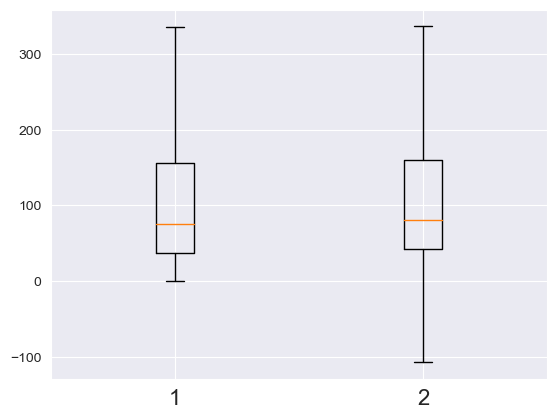

In [11]:
fig, ax = plt.subplots()

ax.boxplot([tauraat['wetted_perimeter1'], tauraat['wetted_perimeter2']], showfliers=False)
# ax.set_xticklabels([xax2_name, yax2_name])
ax.tick_params(axis='x', labelrotation=0, labelsize=16)
ax.grid(True)
plt.show()

In [18]:
tauraat['roughness'] = (1.49 * tauraat['SLOPE']**(0.5) * tauraat['chan_area']**(5.0/3.0))/(tauraat['chan_discharge'] * tauraat['wetted_perimeter']**(2.0/3.0))

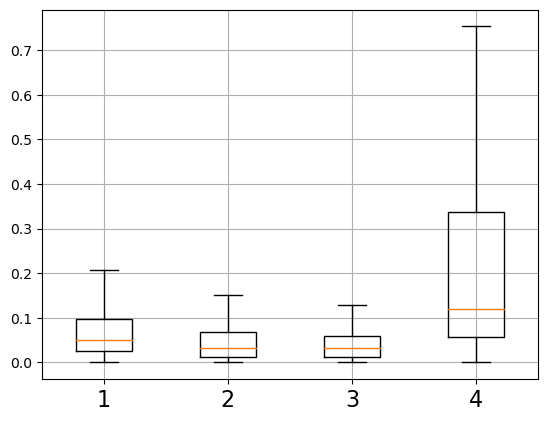

In [20]:
fig, ax = plt.subplots()
st = tauraat[tauraat['FTYPE'] == 'StreamRiver']['roughness']
ap = tauraat[tauraat['FTYPE'] == 'ArtificialPath']['roughness']
cd = tauraat[tauraat['FTYPE'] == 'CanalDitch']['roughness']
cn = tauraat[tauraat['FTYPE'] == 'Connector']['roughness']

ax.boxplot([st, ap, cd, cn], showfliers=False)
# ax.set_xticklabels([xax2_name, yax2_name])
ax.tick_params(axis='x', labelrotation=0, labelsize=16)
ax.grid(True)
plt.show()

In [116]:
def side_slope(m, Q=1.0, A=1.0, T=1.0, Sb=1.0, d=1.0, n=1.0):
    numerator = (Sb**(0.5) * A**(5.0/3.0))
    denominator = n * ((T-2*m*d) + 2*d*(1+m**2)**(0.5))**(2.0/3.0)
    return Q - (numerator/ denominator)

In [117]:
mat = df.to_numpy()[:50]

In [118]:
roots = list()
for vars in mat:

    sol = optimize.root(side_slope, x0=1.00, args=(vars[0], vars[1], vars[2], vars[3], vars[4], vars[5]))
    roots.append(sol.x)

In [120]:
for i, Ss in enumerate(roots):

    print(side_slope(m=Ss, Q=mat[i,0], A=mat[i,1], T=mat[i,2], Sb=mat[i,3], d=mat[i,4], n=mat[i,5]))


[1069.55883657]
[1522.28877841]
[4523.24432982]
[3890.09862788]
[2589.3947106]
[3556.08072731]
[11493.60370461]
[5653.62236897]
[24022.41902244]
[27993.89463255]
[6177.77588091]
[3.63797881e-12]
[3.63797881e-12]
[0.]
[1.18234311e-11]
[-1.8189894e-12]
[764.78753447]
[29762.94134298]
[45717.89407664]
[31457.49377749]
[19888.60178488]
[27558.86205323]
[24419.83923088]
[15363.78263142]
[45054.10994341]
[28444.05874493]
[18330.90706715]
[12315.21421695]
[13250.74728931]
[6048.5536918]
[11384.07169316]
[13731.75620343]
[7551.99359866]
[7621.88127462]
[6627.6574086]
[1977.97682058]
[1142.31085177]
[3022.18977962]
[3587.91723265]
[2589.25152767]
[11256.35004869]
[9811.96641557]
[5683.881015]
[9738.59658733]
[8213.83541674]
[9269.79685004]
[22582.05394182]
[8318.35106643]
[6983.75125002]
[6426.13222975]
